# Basic operations in datamesh


## Install libraries

In [1]:
# Basic libraries
#!pip install numpy matplotlib cartopy

# Base oceanum library
#!pip install oceanum -U

# Jupyter extention for graphical interaction with datamesh
# !pip install oceanumlab

In [6]:
import warnings
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import cartopy.crs as ccrs

from oceanum.datamesh import Connector
from oceanum.datamesh.datasource import Coordinates

plt.rcParams["figure.figsize"] = [20, 10]
warnings.filterwarnings("ignore")

## Connect to datamesh
Define your datamesh token in evironment variables as DATAMESH_TOKEN or insert into argument below.

In [7]:
from oceanum.datamesh import Connector
#Put your datamesh token in the Jupyterlab settings, or as argument in the constructor below
datamesh=Connector()

### Extract gridded data


In [8]:
# We begin by extracting some data. This will serve to demonstrate a simple extraction, 
# but we will also then use this extracted data as a demostration of how to write data 
# to datamesh. Of course this can also be done using data that you have already. 
# Here we are extracting 1year of era5 surface winds over new zealand
# We are using query here, just because its faster for remote access of large datasets as the slicing is done on the server, 
# however you could also use load_datasource to get a lazy view of the full 40+y global dataset and slice as required

era5_nz=datamesh.query({
  "datasource": "era5_wind10m",
  "description": "ECMWF ERA5 global 10m wind hindcast",
  "timefilter": {
    "times": [
      "2000-01-01T00:00:00.000Z",
      "2000-01-07T00:00:00.000Z",
    ]
  },
  "geofilter": {
    "type": "bbox",
    "geom": [
      165,
      -48,
      180,
      -33
    ]
  }
})
era5_nz

<xarray.Dataset> Size: 6MB
Dimensions:    (latitude: 61, longitude: 61, time: 145)
Coordinates:
  * latitude   (latitude) float32 244B -33.0 -33.25 -33.5 ... -47.5 -47.75 -48.0
  * longitude  (longitude) float32 244B 165.0 165.2 165.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 1kB 2000-01-01 ... 2000-01-07
Data variables:
    u10        (time, latitude, longitude) float32 2MB 6.509 6.271 ... 4.804
    v10        (time, latitude, longitude) float32 2MB -6.899 -6.789 ... 2.587
    wspd       (time, latitude, longitude) float32 2MB 9.485 9.242 ... 5.456
Attributes:
    Conventions:    CF-1.6
    history:        2024-06-16 09:49:17 GMT by grib_to_netcdf-2.28.1: /opt/ec...
    _coordinates:   {"t":"time","x":"longitude","y":"latitude"}
    _request_size:  6476188

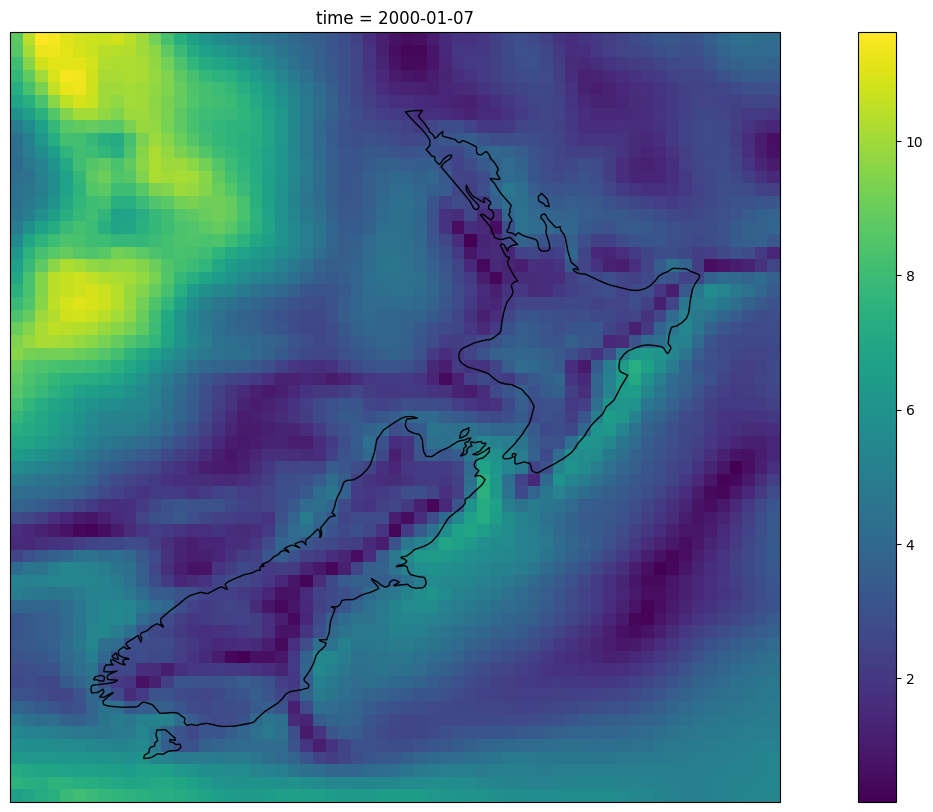

In [9]:
# Lets plot a single wind speed timestep to check the data

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
((era5_nz.u10.isel(time=-1) ** 2 + era5_nz.v10.isel(time=-1) **2 ) ** 0.5).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

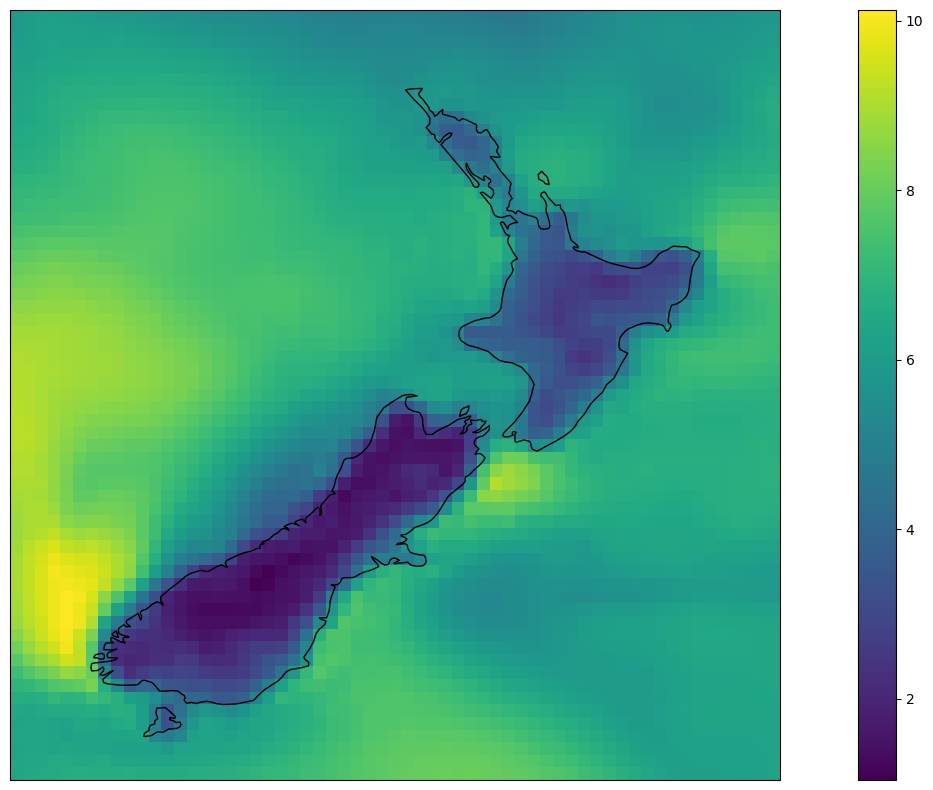

In [19]:
# We can then use this data as we would use a local dataset. For example, lets take the mean over time 
# and plot the results. Note that this is not a large dataset, so this is a relatively trivial example,
# but similar analysis can be undertaken with very large datasets due to dask support). 

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
(np.sqrt(era5_nz.u10 **2 + era5_nz.v10**2)).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Writing data

In [20]:
# Lets now look at writing this extracted data back to datamesh as a new dataset. 
# Before we do that, lets check our current era5 datasets
cat = datamesh.get_catalog('era5')
cat.ids

['oceanum_wave_bass_5km_era5_grid',
 'oceanum_wave_ptlan_1km_era5_spec',
 'oceanum_wave_ense_era5_grid',
 'oceanum_wave_swna_era5_grid',
 'oceanum_wave_ense_era5_spec',
 'oceanum_wave_cali_era5_grid',
 'oceanum_wave_swna_era5_spec',
 'oceanum_wave_cali_era5_spec',
 'oceanum_ocean_otago_schism_zlevels',
 'oceanum_ocean_bass_schism_v1',
 'oceanum_wave_ebass_1km_era5_spec',
 'oceanum_wave_bass_5km_era5_spec',
 'oceanum_wave_ptlan_1km_era5_grid',
 'gridstas_oceanum_wave_glob05_era5_v1',
 'gridstats_oceanum_wave_era5_trki_v1',
 'oceanum_ocean_auckland_schism_v1',
 'gridstats_oceanum_wave_era5_nz_v1',
 'oceanum_wave_ebass_1km_era5_grid',
 'gridstats_oceanum_wave_era5_weuro_v1',
 'era5_wind100m',
 'era5_wind10m',
 'oceanum_wave_glob05_era5_v1_grid',
 'era5_temp2m',
 'oceanum_wave_mediterranean_era5_v1_grid',
 'oceanum_wave_redsea_era5_grid',
 'oceanum_wave_weuro_era5_v1_grid',
 'stats_era5_wind100m',
 'era5_seaicecon',
 'oceanum_wave_redsea_era5_spec',
 'oceanum_wave_nz_era5_v1_grid',
 'ocean

In [21]:
# Lets check the docs to write the datasource
datamesh.write_datasource?

Signature:
datamesh.write_datasource(
    datasource_id,
    data,
    geometry=None,
    coordinates=None,
    geom=None,
    append=None,
    overwrite=False,
    index=None,
    **properties,
)
Docstring:
Write a datasource to datamesh from the work environment

Args:
    datasource_id (string): Unique datasource id
    data (Union[:obj:`pandas.DataFrame`, :obj:`geopandas.GeoDataFrame`, :obj:`xarray.Dataset`, None]):  The data to be written to datamesh. If data is None, just update metadata properties.
    geometry (:obj:`oceanum.datasource.Geometry`, optional): GeoJSON geometry of the datasource
    coordinates (Dict[:obj:`oceanum.datasource.Coordinates`,str], optional): Coordinate mapping for xarray datasets. default=None
    append (string, optional): Coordinate to append on. default=None
    overwrite (bool, optional): Overwrite existing datasource. default=False
    **properties: Additional properties for the datasource - see :obj:`oceanum.datamesh.Datasource`

Returns:
    :ob

In [22]:
# As mentioned in the docs above, lets check the relevant datasource properties that we may want to write
from oceanum.datamesh import Datasource
Datasource?

Init signature:
Datasource(
    *,
    id: Annotated[str, MinLen(min_length=3), MaxLen(max_length=80), _PydanticGeneralMetadata(pattern='^[a-z0-9-_]+$')],
    name: Annotated[str, MaxLen(max_length=128)],
    description: Annotated[Optional[str], MaxLen(max_length=1500)] = '',
    parameters: Optional[dict] = {},
    geom: Optional[Annotated[Union[shapely.geometry.point.Point, shapely.geometry.multipoint.MultiPoint, shapely.geometry.polygon.Polygon], <class 'oceanum.datamesh.datasource._GeometryAnnotation'>]] = None,
    tstart: Optional[datetime.datetime] = None,
    tend: Optional[datetime.datetime] = None,
    pforecast: Optional[Annotated[datetime.timedelta, BeforeValidator(func=<function parse_period at 0x7fe31a09cd60>)]] = None,
    parchive: Optional[Annotated[datetime.timedelta, BeforeValidator(func=<function parse_period at 0x7fe31a09cd60>)]] = None,
    tags: Optional[list] = [],
    info: Optional[dict] = {},
    schema: Optional[oceanum.datamesh.datasource.Schema] = Schema(

In [23]:
# Lets try writing the new data to datamesh. Here we set the tags, times and geom properties to aid searching later
times = era5_nz.time.to_pandas()

datasource = datamesh.write_datasource(datasource_id='era5_nz_10m_wind_demo', 
                          name="NZ ERA5 Surface Winds Subset",
                          description="ERA5 winds over New Zealand", 
                          data=era5_nz, 
                          coordinates={"t":"time","x":"longitude","y":"latitude"},
                          tags=['demo', 'nz', 'era5'],
                          tstart=times[0],
                          tend=times[-1],
                          geom={'type':'Polygon','coordinates':[[[era5_nz.longitude.min(),era5_nz.latitude.min()],
                                                                 [era5_nz.longitude.max(),era5_nz.latitude.min()],
                                                                 [era5_nz.longitude.max(),era5_nz.latitude.max()],
                                                                 [era5_nz.longitude.min(),era5_nz.latitude.max()]]]},
                                                                 
                         )
datasource


        NZ ERA5 Surface Winds Subset [era5_nz_10m_wind_demo]
            Extent: (165.0, -48.0, 180.0, -33.0)
            Timerange: 2000-01-01 00:00:00 to 2000-01-07 00:00:00
            4 attributes
            3 variables
        

In [24]:
# Now if we check again, we should see our demo dataset that we have just written
cat = datamesh.get_catalog('era5')
cat.ids

['oceanum_wave_bass_5km_era5_grid',
 'oceanum_wave_ptlan_1km_era5_spec',
 'oceanum_wave_ense_era5_grid',
 'oceanum_wave_swna_era5_grid',
 'oceanum_wave_ense_era5_spec',
 'oceanum_wave_cali_era5_grid',
 'oceanum_wave_swna_era5_spec',
 'oceanum_wave_cali_era5_spec',
 'oceanum_ocean_otago_schism_zlevels',
 'oceanum_ocean_bass_schism_v1',
 'oceanum_wave_ebass_1km_era5_spec',
 'oceanum_wave_bass_5km_era5_spec',
 'oceanum_wave_ptlan_1km_era5_grid',
 'gridstas_oceanum_wave_glob05_era5_v1',
 'gridstats_oceanum_wave_era5_trki_v1',
 'oceanum_ocean_auckland_schism_v1',
 'gridstats_oceanum_wave_era5_nz_v1',
 'oceanum_wave_ebass_1km_era5_grid',
 'gridstats_oceanum_wave_era5_weuro_v1',
 'era5_wind100m',
 'era5_wind10m',
 'oceanum_wave_glob05_era5_v1_grid',
 'era5_temp2m',
 'oceanum_wave_mediterranean_era5_v1_grid',
 'oceanum_wave_redsea_era5_grid',
 'oceanum_wave_weuro_era5_v1_grid',
 'stats_era5_wind100m',
 'era5_seaicecon',
 'oceanum_wave_redsea_era5_spec',
 'oceanum_wave_nz_era5_v1_grid',
 'ocean

In [25]:
# Now if we check again, we can also search on the tags we have written
cat = datamesh.get_catalog('demo')
cat.ids

['era5_nz_10m_wind_demo', 'oceanum_ww3_tests_grid', 'oceanum_ww3_test_grid']

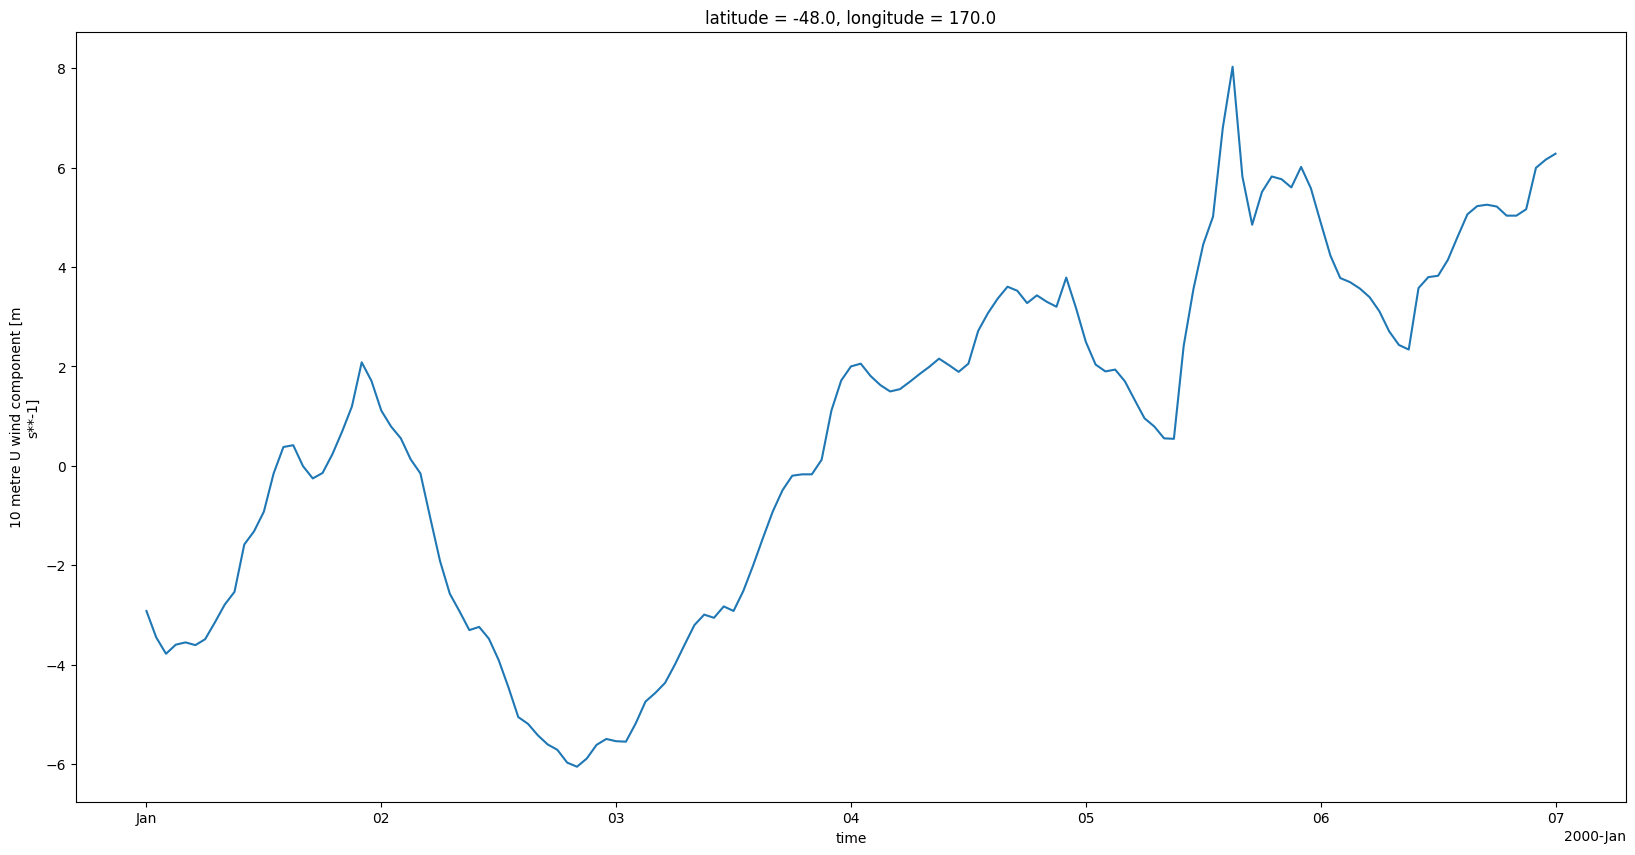

In [26]:
# Now we can treat this dataset like any dataset. 
# For example, lets open the dataset using load_datasource, and extract and plot a single point using standard xarray slicing

ds = datamesh.load_datasource('era5_nz_10m_wind_demo')
ds.u10.sel(latitude=-50, longitude=170, method='nearest').plot()

In [27]:
# Finally, lets delete this demo dataset

datamesh.delete_datasource(datasource_id='era5_nz_10m_wind_demo')

True

In [28]:
# And check thats its gone

cat = datamesh.get_catalog('demo')
cat.ids

['oceanum_ww3_tests_grid', 'oceanum_ww3_test_grid']